In [1]:
! CMAKE_ARGS="-DLIBHEOM_ENABLE_CUDA=OFF -DCMAKE_VERBOSE_MAKEFILE=ON" pip install git+https://github.com/tatsushi-ikeda/pyheom.git@master -v

Using pip 22.0.4 from /usr/local/lib/python3.8/dist-packages/pip (python 3.8)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tatsushi-ikeda/pyheom.git (to revision master) to /tmp/pip-req-build-v4k2hnw7
  Running command git version
  git version 2.25.1
  Running command git clone --filter=blob:none https://github.com/tatsushi-ikeda/pyheom.git /tmp/pip-req-build-v4k2hnw7
  Cloning into '/tmp/pip-req-build-v4k2hnw7'...
  Running command git show-ref master
  9b084f3d8dc4edffb97d8d961bd5038f3aead919 refs/heads/master
  9b084f3d8dc4edffb97d8d961bd5038f3aead919 refs/remotes/origin/master
  Running command git symbolic-ref -q HEAD
  refs/heads/master
  Resolved https://github.com/tatsushi-ikeda/pyheom.git to commit 9b084f3d8dc4edffb97d8d961bd5038f3aead919
  Running command git submodule update --init --recursive -q
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-w4

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse

from sys import stdout, stderr
import time

import pyheom
from pyheom import heom_solver, redfield_solver, noise_decomposition, drude, unit
pyheom.units['energy'] = unit.wavenumber
pyheom.units['time']   = unit.femtosecond
from tqdm.auto import tqdm

dtype           = np.complex128

epsilon_1 = 100.0
epsilon_2 = 0.0
J_12      = 100.0
gamma     = 53.08
beta      = 1/208.51
lambda_c  = J_12/5.0

callback_interval = 1
count             = 1000
t_list            = np.arange(0, count, callback_interval)
solver_params    = dict(
    dt = 5e-2,
    # atol=1e-6, rtol=1e-3
)
# 

J_1 = drude(eta = 2*lambda_c/gamma, gamma_c = gamma)
J_2 = drude(eta = 2*lambda_c/gamma, gamma_c = gamma)
corr_dict_1 = noise_decomposition(
    J_1,
    T = 1/beta,
    type_ltc = 'none'
)
corr_dict_2 = noise_decomposition(
    J_2,
    T = 1/beta,
    type_ltc = 'none'
)

n_level = 2
depth = 50

H = np.array([[epsilon_1+lambda_c, J_12],
              [J_12, epsilon_2+lambda_c]],
             dtype=dtype)

V_1 = np.array([[1, 0],
                [0, 0]],
             dtype=dtype)

V_2 = np.array([[0, 0],
                [0, 1]],
             dtype=dtype)


In [3]:
print(corr_dict_1)
# Symmetrized correlation function : sigma.T@S@exp(-gamma*t)@phi_0 + s_delta*2*delta(t)
# Anti-symmetrized correlation function : sigma.T@A@exp(-gamma*t)@phi_0
# If you want to use custom correlation functions, specify the above parameters directly.
# Because gamma, S, and A are matrices and phi_0 and sigma are vectors, sum of exponential functions (diagonal gamma) and non-exponential funcitons (non-diagonal gamma) can be written in the above format.

{'gamma': <1x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in List of Lists format>, 'sigma': array([1.+0.j]), 'phi_0': array([1.+0.j]), 'S': <1x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in List of Lists format>, 's_delta': 0.0, 'A': <1x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 1 stored elements in List of Lists format>}


In [4]:
space           = 'ado'       # 'hilbert', 'liouville'
format          = 'sparse'    # 'dense'
engine          = 'eigen'     # 'cuda', 'mkl'
solver          = 'lsrk4'
order_liouville = 'row_major' # 'col_major'
space           = 'ado'
# The above configurations strongly affect the numerical performance of the computation.
# The optimal choice depends on the sizes of the system and hierarchy space.

qme = heom_solver(H, [dict(V=V_1, **corr_dict_1), dict(V=V_2, **corr_dict_2)],
                  space=space, format=format, engine=engine,
                  order_liouville=order_liouville,
                  solver=solver,
                  engine_args=dict(),
                  depth = depth)

n_storage = qme.storage_size()

rho = np.zeros((n_storage,n_level,n_level), dtype=dtype)
rho_0 = rho[0,:,:]
rho_0[0,0] = 1

pop_save_heom = np.zeros((t_list.shape[0],))
count    = 0

with tqdm(total=t_list.shape[0]) as bar:
    def callback(t):
        global count
        bar.update(1)
        pop_save_heom[count] = rho_0[0,0].real
        count += 1
    begin = time.time()
    qme.solve(rho, t_list, callback=callback, **solver_params)
    end   = time.time()
print('elapsed:', end - begin, file=stderr)
del qme

  0%|          | 0/1000 [00:00<?, ?it/s]

elapsed: 23.122908353805542


In [5]:
space='liouville'
qme = redfield_solver(H, [dict(V=V_1, **corr_dict_1), dict(V=V_2, **corr_dict_2)],
                      space=space, format=format, engine=engine,
                      order_liouville=order_liouville,
                      solver=solver,
                      engine_args=dict())

n_storage = qme.storage_size()

rho = np.zeros((n_storage,n_level,n_level), dtype=dtype)
rho_0 = rho[0,:,:]
rho_0[0,0] = 1

pop_save_rf = np.zeros((t_list.shape[0],))
count    = 0

with tqdm(total=t_list.shape[0]) as bar:
    def callback(t):
        global count
        bar.update(1)
        pop_save_rf[count] = rho_0[0,0].real
        count += 1
    begin = time.time()
    qme.solve(rho, t_list, callback=callback, **solver_params)
    end   = time.time()
print('elapsed:', end - begin, file=stderr)
del qme

  0%|          | 0/1000 [00:00<?, ?it/s]

elapsed: 0.03078460693359375


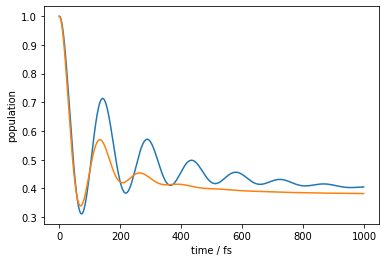

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, 
                     xlabel='time / fs', 
                     ylabel='population')
ax.plot(t_list, pop_save_heom)
ax.plot(t_list, pop_save_rf)